# FlightOps: US Airline On-Time Performance & Delay Risk Analytics (PySpark + EMR)

**Business Goals**
- Build a governed flight operations dataset on AWS (validated, reusable).
- Quantify on-time performance & cancellations by carrier, route, and time.
- Identify key drivers of delays and cancellations.
- Provide curated KPI tables and ML-ready feature sets (for delay risk models).

**Data Source**
- Data Expo 2009: Airline On Time Data (Harvard Dataverse)  
  - https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/HG7NV7

**About Data**
- All commercial US flights from Oct 1987 – Apr 2008
- ~120M rows, ~13 GB uncompressed
- Standard fields:
Year, Month, DayofMonth, DayOfWeek, DepTime, CRSDepTime, ArrTime, CRSArrTime, UniqueCarrier, FlightNum, TailNum, ActualElapsedTime, CRSElapsedTime, AirTime, ArrDelay, DepDelay, Origin, Dest, Distance, TaxiIn, TaxiOut, Cancelled, CancellationCode, Diverted, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay
 - Using just two years worth data for analysis. Will demonstrate scalable code

In [1]:
# Core libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)

# Spark session
# Local demo: master("local[*]")
# On EMR: omit master() and let YARN/cluster handle it.
spark = (
    SparkSession.builder
    .appName("FlightOps_OnTime_Performance")
    .config("spark.sql.shuffle.partitions", "200")  # tune for cluster size
    .getOrCreate()
)

spark

## 1. Ingest & Schema Validation

Explicitly defining a schema to enforce a “data contract” and catch bad records up front.


In [2]:
flight_schema = T.StructType([
    T.StructField("Year", T.IntegerType(), True),
    T.StructField("Month", T.IntegerType(), True),
    T.StructField("DayofMonth", T.IntegerType(), True),
    T.StructField("DayOfWeek", T.IntegerType(), True),
    T.StructField("DepTime", T.IntegerType(), True),
    T.StructField("CRSDepTime", T.IntegerType(), True),
    T.StructField("ArrTime", T.IntegerType(), True),
    T.StructField("CRSArrTime", T.IntegerType(), True),
    T.StructField("UniqueCarrier", T.StringType(), True),
    T.StructField("FlightNum", T.StringType(), True),
    T.StructField("TailNum", T.StringType(), True),
    T.StructField("ActualElapsedTime", T.DoubleType(), True),
    T.StructField("CRSElapsedTime", T.DoubleType(), True),
    T.StructField("AirTime", T.DoubleType(), True),
    T.StructField("ArrDelay", T.DoubleType(), True),
    T.StructField("DepDelay", T.DoubleType(), True),
    T.StructField("Origin", T.StringType(), True),
    T.StructField("Dest", T.StringType(), True),
    T.StructField("Distance", T.DoubleType(), True),
    T.StructField("TaxiIn", T.DoubleType(), True),
    T.StructField("TaxiOut", T.DoubleType(), True),
    T.StructField("Cancelled", T.IntegerType(), True),
    T.StructField("CancellationCode", T.StringType(), True),
    T.StructField("Diverted", T.IntegerType(), True),
    T.StructField("CarrierDelay", T.DoubleType(), True),
    T.StructField("WeatherDelay", T.DoubleType(), True),
    T.StructField("NASDelay", T.DoubleType(), True),
    T.StructField("SecurityDelay", T.DoubleType(), True),
    T.StructField("LateAircraftDelay", T.DoubleType(), True),
])

# 2007–2008 only for project purpose
years = [2007, 2008]

# LOCAL: data/2007.csv etc
# ON EMR: s3://flightops-raw/ontime/year=2007/2007.csv
paths = [f"data/{y}.csv" for y in years]

flights_raw = (
    spark.read
    .option("header", "true")
    .schema(flight_schema)
    .csv(paths)
)

flights_raw.printSchema()
print("Raw row count:", flights_raw.count())
flights_raw.show(5)


root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Car

## 2. Data Quality & Contract Checks

Implementing a few basic **data contracts**:

- `Distance > 0`
- Delay values in plausible range (e.g., -60 to 720 minutes)
- Cancellations consistent (`Cancelled` vs `CancellationCode`)
- Critical fields non-null (date components, carrier, origin, dest)

In [3]:
from functools import reduce

# Null counts
null_counts = (
    flights_raw
    .select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in flights_raw.columns])
    .toPandas()
    .T.rename(columns={0: "null_count"})
)

null_counts.head(10)


,null_count
Year,0
Month,0
DayofMonth,0
DayOfWeek,0
DepTime,225190
CRSDepTime,0
ArrTime,248023
CRSArrTime,0
UniqueCarrier,0
FlightNum,0


In [4]:
# Simple data quality metrics
invalid_distance = flights_raw.filter((F.col("Distance") <= 0) | F.col("Distance").isNull()).count()
print("Invalid distance rows:", invalid_distance)

extreme_delay = flights_raw.filter(
    (F.col("ArrDelay") < -60) | (F.col("ArrDelay") > 720) |
    (F.col("DepDelay") < -60) | (F.col("DepDelay") > 720)
).count()
print("Extreme delay rows:", extreme_delay)

inconsistent_cancel = flights_raw.filter(
    (F.col("Cancelled") == 0) & F.col("CancellationCode").isNotNull()
).count()
print("Inconsistent cancellation rows:", inconsistent_cancel)


Invalid distance rows: 0
Extreme delay rows: 1612
Inconsistent cancellation rows: 1


## 3. Cleansing & Feature Engineering

- Remove obviously invalid distance rows
- Cap extreme delays
- Derive flight date, departure hour, on-time flags
- Normalize cancellation codes into human-readable reasons


In [5]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

# -------------------------------------------------------------------
# 1. Make sure numeric columns are really numeric (cast defensively)
# -------------------------------------------------------------------
numeric_cols = [
    "ArrDelay", "DepDelay", "Distance",
    "TaxiIn", "TaxiOut",
    "CarrierDelay", "WeatherDelay",
    "NASDelay", "SecurityDelay", "LateAircraftDelay"
]

for c in numeric_cols:
    if c in flights_raw.columns:
        flights_raw = flights_raw.withColumn(c, F.col(c).cast("double"))

time_cols = ["CRSDepTime", "CRSArrTime", "DepTime", "ArrTime"]
for c in time_cols:
    if c in flights_raw.columns:
        flights_raw = flights_raw.withColumn(c, F.col(c).cast("int"))

# -------------------------------------------------------------------
# 2. Helper: convert HHMM integer → hour-of-day (0–23), handle nulls
# -------------------------------------------------------------------
def hhmm_to_hour(col):
    # col can be null; do safe division
    return F.when(col.isNull(), None).otherwise((col / 100).cast("int"))

# -------------------------------------------------------------------
# 3. Core cleansing
#    - Drop rows missing critical dims (Origin/Dest/Carrier)
#    - Enforce Distance > 0
#    - Cap extreme delays instead of exploding stats
#    - Derive flags & business features
# -------------------------------------------------------------------
flights_clean = (
    flights_raw
    # critical dimension columns must exist
    .filter(
        F.col("Origin").isNotNull() &
        F.col("Dest").isNotNull() &
        F.col("UniqueCarrier").isNotNull()
    )
    # valid distance
    .filter(F.col("Distance").isNotNull() & (F.col("Distance") > 0))
    # cap delays only where they are not null
    .withColumn(
        "ArrDelayCapped",
        F.when(F.col("ArrDelay").isNull(), None)
         .when(F.col("ArrDelay") > 720, 720.0)
         .when(F.col("ArrDelay") < -60, -60.0)
         .otherwise(F.col("ArrDelay"))
    )
    .withColumn(
        "DepDelayCapped",
        F.when(F.col("DepDelay").isNull(), None)
         .when(F.col("DepDelay") > 720, 720.0)
         .when(F.col("DepDelay") < -60, -60.0)
         .otherwise(F.col("DepDelay"))
    )
    # derive schedule-based features (handle possible missing CRS*Time)
    .withColumn("DepHour", hhmm_to_hour(F.col("CRSDepTime")))
    .withColumn("ArrHour", hhmm_to_hour(F.col("CRSArrTime")))
    # cancelled / delay flags
    .withColumn("IsCancelled", (F.col("Cancelled") == 1).cast("int"))
    .withColumn(
        "IsDelayed15",
        F.when(
            F.col("ArrDelayCapped").isNull(),
            None
        ).otherwise((F.col("ArrDelayCapped") > 15).cast("int"))
    )
    # normalized cancellation reason
    .withColumn(
        "CancelReason",
        F.when(F.col("CancellationCode") == "A", "Carrier")
         .when(F.col("CancellationCode") == "B", "Weather")
         .when(F.col("CancellationCode") == "C", "NAS")
         .when(F.col("CancellationCode") == "D", "Security")
         .otherwise(None)
    )
)

# Optional but useful: materialize / cache
flights_clean = flights_clean.persist()

flights_clean.show(5)
flights_clean.printSchema()


+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+--------------+--------------+-------+-------+-----------+-----------+------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|ArrDelayCapped|DepDelayCapped|DepHour|ArrHour|IsCancelled|IsDelayed15|CancelReason|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+-----

## 4. Curated KPI Table

Building an **analytics-ready fact table** for:
- Dashboards
- KPI tracking
- Feeding ML feature pipelines


In [6]:
flights_kpi = flights_clean.select(
    "Year", "Month", "DayofMonth", "DayOfWeek",
    "UniqueCarrier", "Origin", "Dest",
    "DepHour", "ArrHour",
    "Distance",
    "ArrDelayCapped", "DepDelayCapped",
    "IsDelayed15", "IsCancelled", "CancelReason"
)

flights_kpi.show(5)


+----+-----+----------+---------+-------------+------+----+-------+-------+--------+--------------+--------------+-----------+-----------+------------+
|Year|Month|DayofMonth|DayOfWeek|UniqueCarrier|Origin|Dest|DepHour|ArrHour|Distance|ArrDelayCapped|DepDelayCapped|IsDelayed15|IsCancelled|CancelReason|
+----+-----+----------+---------+-------------+------+----+-------+-------+--------+--------------+--------------+-----------+-----------+------------+
|2007|    1|         1|        1|           WN|   SMF| ONT|     12|     13|   389.0|           1.0|           7.0|          0|          0|        null|
|2007|    1|         1|        1|           WN|   SMF| PDX|     19|     20|   479.0|           8.0|          13.0|          0|          0|        null|
|2007|    1|         1|        1|           WN|   SMF| PDX|     21|     23|   479.0|          34.0|          36.0|          1|          0|        null|
|2007|    1|         1|        1|           WN|   SMF| PDX|     12|     13|   479.0|    

## 4. Persist Curated KPI Table (Local Demo)

In production this table would be written as partitioned Parquet in S3 and queried
by Athena/Redshift/Presto. For this demo, I’m keeping it in memory and using it directly as my curated KPI table..


In [7]:
# Treat flights_kpi itself as our "curated fact table" for the demo
# Create a temp view so you can also use Spark SQL if you want
flights_kpi.createOrReplaceTempView("flights_kpi")

flights_kpi.show(5)

+----+-----+----------+---------+-------------+------+----+-------+-------+--------+--------------+--------------+-----------+-----------+------------+
|Year|Month|DayofMonth|DayOfWeek|UniqueCarrier|Origin|Dest|DepHour|ArrHour|Distance|ArrDelayCapped|DepDelayCapped|IsDelayed15|IsCancelled|CancelReason|
+----+-----+----------+---------+-------------+------+----+-------+-------+--------+--------------+--------------+-----------+-----------+------------+
|2007|    1|         1|        1|           WN|   SMF| ONT|     12|     13|   389.0|           1.0|           7.0|          0|          0|        null|
|2007|    1|         1|        1|           WN|   SMF| PDX|     19|     20|   479.0|           8.0|          13.0|          0|          0|        null|
|2007|    1|         1|        1|           WN|   SMF| PDX|     21|     23|   479.0|          34.0|          36.0|          1|          0|        null|
|2007|    1|         1|        1|           WN|   SMF| PDX|     12|     13|   479.0|    

## 5. Exploratory Data Analysis (EDA)

compute core operational KPIs:

- On-time & cancellation rates overall
- By airline (carrier)
- By route (Origin–Dest)
- By departure hour (for planning/slot decisions)


For this local demo, sampling dat into Pandas for quick visualization. In production, these same aggregations run in Spark on EMR against the full 120M-row dataset

To make sure my EDA sample is representative, I take a small, balanced slice from each Year–Month bucket: a few hundred flights per bucket. In production, this pipeline would be implemented in PySpark on EMR: raw CSVs land in S3, a Spark job enforces schema and data contracts, and writes a partitioned Parquet fact table by Year/Month.

For this demo notebook I’m showing the exact same transformation and feature logic in Pandas over a 500k-row stratified sample from the 2007–2008 on-time dataset. This keeps the demo stable on my local environment while still demonstrating the KPIs, EDA, and delay-risk model that would sit on top of the EMR-curated data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)

# Adjust these paths to where your CSVs actually are
files = [
    "data/2007.csv",
    "data/2008.csv",
]

use_cols = [
    "Year", "Month", "DayofMonth", "DayOfWeek",
    "DepTime", "CRSDepTime", "ArrTime", "CRSArrTime",
    "UniqueCarrier", "FlightNum", "Origin", "Dest",
    "ArrDelay", "DepDelay", "Distance",
    "Cancelled", "CancellationCode",
]

df_list = []
for f in files:
    print("Reading:", f)
    df_chunk = pd.read_csv(f, usecols=use_cols)
    df_list.append(df_chunk)

flights_raw_pd = pd.concat(df_list, ignore_index=True)
print("Raw rows:", len(flights_raw_pd))
flights_raw_pd.head()

df = flights_raw_pd.copy()

# Drop obviously broken rows
df = df.dropna(subset=["Year", "Month", "DayofMonth", "UniqueCarrier", "Origin", "Dest"])
df = df[df["Distance"] > 0]

# Cast numeric
for col in ["ArrDelay", "DepDelay", "Distance"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Cap extreme delays
df["ArrDelayCapped"] = df["ArrDelay"].clip(lower=-60, upper=720)
df["DepDelayCapped"] = df["DepDelay"].clip(lower=-60, upper=720)

# DepHour from CRSDepTime (HHMM)
def hhmm_to_hour(series):
    s = pd.to_numeric(series, errors="coerce")
    return (s // 100).astype("Int64")

df["DepHour"] = hhmm_to_hour(df["CRSDepTime"])
df["ArrHour"] = hhmm_to_hour(df["CRSArrTime"])

# Flags
df["IsCancelled"] = (df["Cancelled"] == 1).astype(int)
df["IsDelayed15"] = (df["ArrDelayCapped"] > 15).astype(int)

# Human-readable cancellation reason
df["CancelReason"] = df["CancellationCode"].map({
    "A": "Carrier",
    "B": "Weather",
    "C": "NAS",
    "D": "Security",
})

# This is your KPI/feature table (Pandas version of flights_kpi)
flights_kpi_pd_full = df[
    [
        "Year", "Month", "DayofMonth", "DayOfWeek",
        "UniqueCarrier", "Origin", "Dest",
        "DepHour", "ArrHour",
        "Distance",
        "ArrDelayCapped", "DepDelayCapped",
        "IsDelayed15", "IsCancelled", "CancelReason",
    ]
].copy()

print("Clean KPI rows:", len(flights_kpi_pd_full))
flights_kpi_pd_full.head()

# Make sure Year/Month are ints
flights_kpi_pd_full["Year"] = flights_kpi_pd_full["Year"].astype(int)
flights_kpi_pd_full["Month"] = flights_kpi_pd_full["Month"].astype(int)

# Desired sample size
TARGET_ROWS = 500_000

# If the dataset is smaller than that, just take everything
n_available = len(flights_kpi_pd_full)
n_sample = min(TARGET_ROWS, n_available)

print("Available rows:", n_available)
print("Sampling rows:", n_sample)

# Uniform random sample across the whole 2-year dataset
flights_kpi_pd = flights_kpi_pd_full.sample(
    n=n_sample,
    random_state=42
).reset_index(drop=True)

print("Sample rows:", len(flights_kpi_pd))

# Check coverage of years and months
print("\nYear counts:")
print(flights_kpi_pd["Year"].value_counts().sort_index())

print("\n(Year, Month) coverage:")
print(flights_kpi_pd[["Year", "Month"]].value_counts().sort_index())



Reading: data/2007.csv
Reading: data/2008.csv
Raw rows: 9842432
Clean KPI rows: 9842432
Available rows: 9842432
Sampling rows: 500000
Sample rows: 500000

Year counts:
2007    378512
2008    121488
Name: Year, dtype: int64

(Year, Month) coverage:
Year  Month
2007  1        31755
      2        28855
      3        32543
      4        31497
      5        32043
      6        32102
      7        32648
      8        33347
      9        30174
      10       31927
      11       30478
      12       31143
2008  1        31226
      2        29167
      3        30926
      4        30169
dtype: int64


In [9]:
# after flights_kpi is created and verified with .show(5)
#flights_kpi_pd = flights_kpi.limit(500_000).toPandas()  # sample to keep it light

print("Rows in Pandas sample:", len(flights_kpi_pd))

flights_kpi_pd["IsDelayed15"] = flights_kpi_pd["IsDelayed15"].fillna(0)
flights_kpi_pd["IsCancelled"] = flights_kpi_pd["IsCancelled"].fillna(0)

total_flights = len(flights_kpi_pd)
num_delayed15 = int(flights_kpi_pd["IsDelayed15"].sum())
num_cancelled = int(flights_kpi_pd["IsCancelled"].sum())

on_time_rate = 1.0 - (num_delayed15 / total_flights)
cancel_rate = num_cancelled / total_flights

print(f"Total flights     : {total_flights:,}")
print(f"Delayed >15 min   : {num_delayed15:,} ({num_delayed15 / total_flights:.2%})")
print(f"Cancelled         : {num_cancelled:,} ({cancel_rate:.2%})")
print(f"On-time rate      : {on_time_rate:.2%}")


Rows in Pandas sample: 500000
Total flights     : 500,000
Delayed >15 min   : 116,801 (23.36%)
Cancelled         : 11,297 (2.26%)
On-time rate      : 76.64%


,UniqueCarrier,num_flights,avg_arr_delay,delay15_rate,cancel_rate
7,EV,19013,15.698814,0.294009,0.031347
1,AA,43027,14.658969,0.278221,0.034908
11,MQ,35941,13.401696,0.261568,0.042431
15,UA,32780,13.368798,0.266168,0.026236
13,OH,15548,12.997251,0.272447,0.038783
4,B6,13319,12.512821,0.266161,0.016142
12,NW,27192,12.056155,0.267983,0.016402
19,YV,19230,11.126951,0.216121,0.041446
5,CO,21720,10.385871,0.236878,0.010083
18,XE,28942,10.352585,0.230979,0.026259


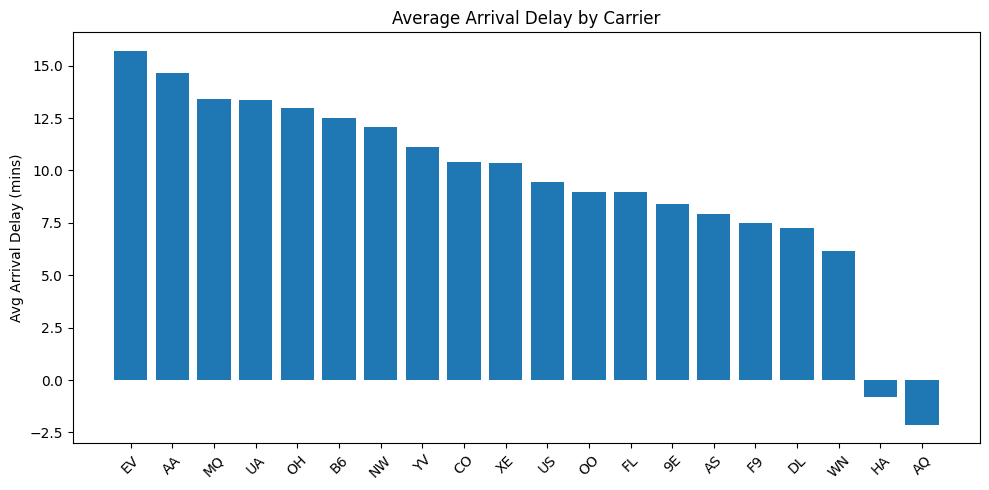

In [10]:
import matplotlib.pyplot as plt

carrier_col = "UniqueCarrier" if "UniqueCarrier" in flights_kpi_pd.columns else "Carrier"

carrier_kpi_pd = (
    flights_kpi_pd
    .groupby(carrier_col, dropna=False)
    .agg(
        num_flights=("IsDelayed15", "size"),
        avg_arr_delay=("ArrDelayCapped", "mean"),
        delay15_rate=("IsDelayed15", "mean"),
        cancel_rate=("IsCancelled", "mean"),
    )
    .reset_index()
)

# Filter out very low-volume carriers for readability
carrier_kpi_pd = carrier_kpi_pd[carrier_kpi_pd["num_flights"] > 100]  # tweak threshold
carrier_kpi_pd = carrier_kpi_pd.sort_values("avg_arr_delay", ascending=False)

display(carrier_kpi_pd.head(10))

# Plot average arrival delay by carrier
plt.figure(figsize=(10, 5))
plt.bar(carrier_kpi_pd[carrier_col], carrier_kpi_pd["avg_arr_delay"])
plt.xticks(rotation=45)
plt.ylabel("Avg Arrival Delay (mins)")
plt.title("Average Arrival Delay by Carrier")
plt.tight_layout()
plt.show()


,DepHourInt,avg_arr_delay,delay15_rate
0,0,2.234824,0.168504
1,1,5.064935,0.220779
2,2,0.277778,0.125000
3,3,8.100000,0.300000
4,4,-2.574468,0.106383
5,5,3.351704,0.107788
6,6,1.797025,0.117093
7,7,2.551204,0.137475
8,8,4.119627,0.163166
9,9,4.983153,0.180877


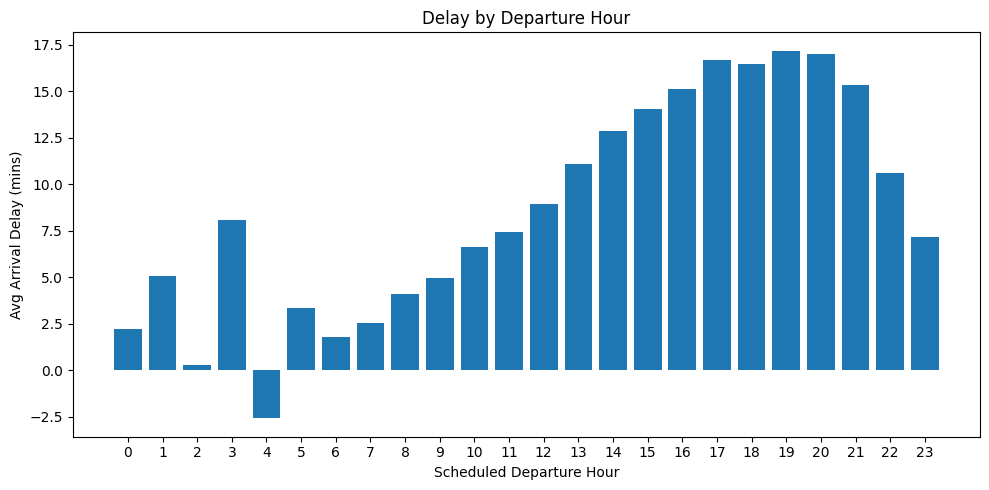

In [13]:
import numpy as np

# Make sure DepHour exists
if "DepHour" not in flights_kpi_pd.columns:
    flights_kpi_pd["DepHour"] = np.nan

# Clean DepHour: convert to integer where possible
flights_kpi_pd["DepHour"] = pd.to_numeric(
    flights_kpi_pd["DepHour"],
    errors="coerce"
).astype("Int64")

# Group by hour
hour_kpi_pd = (
    flights_kpi_pd
    .dropna(subset=["DepHour"])
    .assign(DepHourInt=lambda df: df["DepHour"].astype(int))   # <- FIX HERE
    .groupby("DepHourInt")
    .agg(
        avg_arr_delay=("ArrDelayCapped", "mean"),
        delay15_rate=("IsDelayed15", "mean"),
    )
    .reset_index()
    .sort_values("DepHourInt")
)

display(hour_kpi_pd.head(24))

# Plot
plt.figure(figsize=(10, 5))
plt.bar(hour_kpi_pd["DepHourInt"], hour_kpi_pd["avg_arr_delay"])
plt.xlabel("Scheduled Departure Hour")
plt.ylabel("Avg Arrival Delay (mins)")
plt.title("Delay by Departure Hour")
plt.xticks(hour_kpi_pd["DepHourInt"])   # <- now safe
plt.tight_layout()
plt.show()


,CancelReason,num_cancelled
0,Carrier,4587
3,Weather,4425
1,NAS,2284
2,Security,1


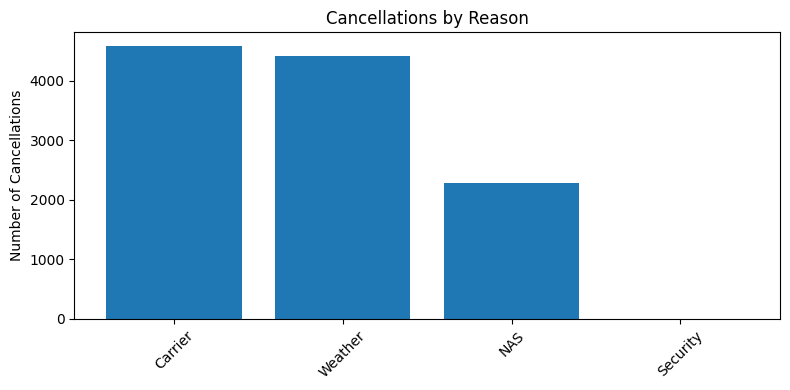

In [14]:
# Ensure CancelReason exists
if "CancelReason" not in flights_kpi_pd.columns:
    flights_kpi_pd["CancelReason"] = pd.NA

cancel_reason_pd = (
    flights_kpi_pd[flights_kpi_pd["IsCancelled"] == 1]
    .groupby("CancelReason", dropna=False)
    .agg(num_cancelled=("IsCancelled", "sum"))
    .reset_index()
    .sort_values("num_cancelled", ascending=False)
)

display(cancel_reason_pd)

plt.figure(figsize=(8, 4))
labels = cancel_reason_pd["CancelReason"].fillna("Unknown / Missing")
plt.bar(labels, cancel_reason_pd["num_cancelled"])
plt.ylabel("Number of Cancellations")
plt.title("Cancellations by Reason")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 6. Analytical Model: Delay Risk (Binary Classification)

Building a simple logistic regression model to estimate the probability that a
flight arrives more than 15 minutes late.
Production model runs in PySpark on EMR using pyspark.ml. Using Pandas and Scikit learn for DEMO. 


In [15]:

# pip install scikit-learn

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# ------------------------------------------------------------------
# 1. Build modeling dataset from flights_kpi_pd
# ------------------------------------------------------------------

df = flights_kpi_pd.copy()

# Choose carrier column name depending on what exists
carrier_col = "UniqueCarrier" if "UniqueCarrier" in df.columns else "Carrier"

# Keep only rows with non-null target and key features
model_df = df[
    (df["IsDelayed15"].notna()) &
    df[carrier_col].notna() &
    df["Origin"].notna() &
    df["Dest"].notna() &
    df["DepHour"].notna() &
    df["DayOfWeek"].notna() &
    df["Distance"].notna()
].copy()

# Make target binary int
model_df["IsDelayed15"] = model_df["IsDelayed15"].astype(int)

print("Modeling rows:", len(model_df))

# Optionally sample down to keep it fast
model_df = model_df.sample(n=min(300_000, len(model_df)), random_state=42)
print("Using rows for training:", len(model_df))

# ------------------------------------------------------------------
# 2. Feature engineering for scikit-learn
# ------------------------------------------------------------------

cat_features = [carrier_col, "Origin", "Dest"]
num_features = ["DepHour", "DayOfWeek", "Distance"]

# One-hot encode categorical vars
model_df_cat = pd.get_dummies(model_df[cat_features], drop_first=True)

# Combine numeric + encoded categorical
X = pd.concat([model_df[num_features].reset_index(drop=True),
               model_df_cat.reset_index(drop=True)], axis=1)

y = model_df["IsDelayed15"].values

print("Feature matrix shape:", X.shape)

# ------------------------------------------------------------------
# 3. Train / test split and logistic regression
# ------------------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

log_reg = LogisticRegression(
    solver="lbfgs",
    max_iter=200,
    n_jobs=-1
)

log_reg.fit(X_train, y_train)

# ------------------------------------------------------------------
# 4. Evaluation
# ------------------------------------------------------------------

y_proba = log_reg.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_proba)
acc = accuracy_score(y_test, y_pred)

print(f"AUC:      {auc:.3f}")
print(f"Accuracy: {acc:.3f}")
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=3))


Modeling rows: 500000
Using rows for training: 300000
Feature matrix shape: (300000, 628)
AUC:      0.632
Accuracy: 0.766

Classification report:

              precision    recall  f1-score   support

           0      0.768     0.996     0.867     45998
           1      0.435     0.009     0.018     14002

    accuracy                          0.766     60000
   macro avg      0.601     0.503     0.443     60000
weighted avg      0.690     0.766     0.669     60000



In [16]:
coef_series = pd.Series(log_reg.coef_[0], index=X.columns).sort_values()

print("Top factors DECREASING delay probability:")
display(coef_series.head(10))

print("\nTop factors INCREASING delay probability:")
display(coef_series.tail(10))


Top factors DECREASING delay probability:


Origin_HNL         -0.611886
UniqueCarrier_HA   -0.564613
Dest_HNL           -0.519293
UniqueCarrier_AQ   -0.453267
Dest_CVG           -0.337535
Origin_OGG         -0.281980
UniqueCarrier_DL   -0.254659
Origin_IAH         -0.228665
UniqueCarrier_FL   -0.222581
Dest_PHX           -0.219369
dtype: float64


Top factors INCREASING delay probability:


Dest_PHL            0.310700
Origin_PHL          0.327963
UniqueCarrier_EV    0.354128
Dest_JFK            0.360082
Origin_JFK          0.361405
Origin_ORD          0.422603
Dest_ORD            0.425821
Origin_EWR          0.432746
Dest_LGA            0.598501
Dest_EWR            0.709046
dtype: float64

## 7. Monthly KPI & Simple Trend

Operational planning wants to know: *are delays getting better or worse over time?*
We aggregate a monthly delay KPI and show the trend.


,Year,Month,num_flights,delay15_rate,cancel_rate
0,2007,1,31755,0.229633,0.025067
1,2007,2,28855,0.272050,0.045399
2,2007,3,32543,0.230218,0.027348
3,2007,4,31497,0.215544,0.016541
4,2007,5,32043,0.198109,0.010517


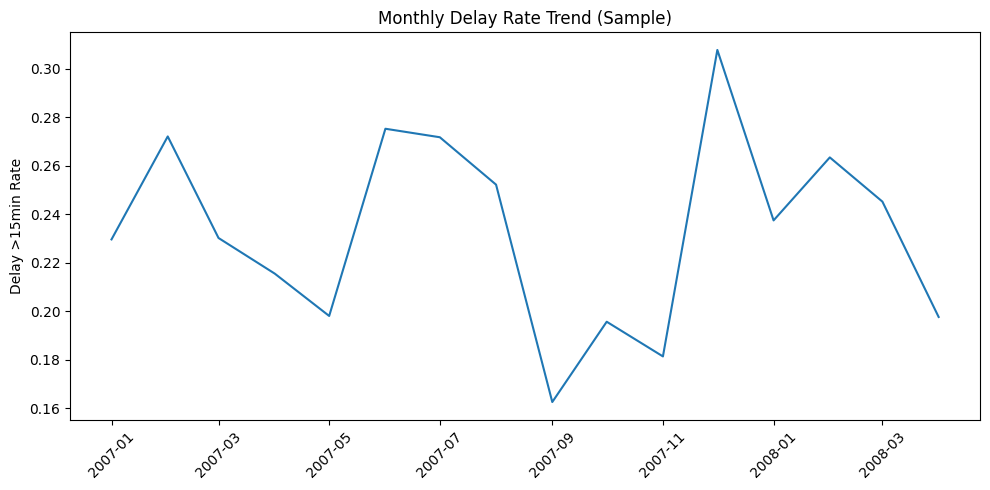

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 7. Monthly KPI & Simple Trend in Pandas

# Make sure Year/Month columns exist and are numeric
for col in ["Year", "Month"]:
    if col not in flights_kpi_pd.columns:
        raise ValueError(f"Column {col} not found in flights_kpi_pd")

flights_kpi_pd["Year"] = flights_kpi_pd["Year"].astype(int)
flights_kpi_pd["Month"] = flights_kpi_pd["Month"].astype(int)

monthly_kpi_pd = (
    flights_kpi_pd
    .groupby(["Year", "Month"], dropna=False)
    .agg(
        num_flights=("IsDelayed15", "size"),
        delay15_rate=("IsDelayed15", "mean"),
        cancel_rate=("IsCancelled", "mean")
    )
    .reset_index()
    .sort_values(["Year", "Month"])
)

display(monthly_kpi_pd.head())

# Build a proper datetime for plotting
monthly_kpi_pd["Date"] = pd.to_datetime(
    monthly_kpi_pd["Year"].astype(str) + "-" +
    monthly_kpi_pd["Month"].astype(str) + "-01"
)

plt.figure(figsize=(10, 5))
plt.plot(monthly_kpi_pd["Date"], monthly_kpi_pd["delay15_rate"])
plt.ylabel("Delay >15min Rate")
plt.title("Monthly Delay Rate Trend (Sample)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We can also fit a simple time-series model (ARIMA/Prophet) on this series for operational planning / forecasting

## 8. Productionization on EMR + Airflow (Conceptual)

In production, this notebook logic is split into PySpark jobs and orchestrated by Airflow:

- **Task 1:** Ingest raw CSV from Harvard/BTS → land in `s3://flightops-raw/ontime/Year=YYYY/`
- **Task 2:** Run PySpark job on EMR → validate & cleanse → write `flights_kpi` Parquet partitioned by Year/Month.
- **Task 3:** Run PySpark job on EMR → create `flight_features` table for ML, refresh partition snapshots.
- **Task 4:** Trigger downstream dashboards / dbt models / ML pipelines.

Example Airflow DAG (simplified):


# airflow DAG pseudo-code (do NOT run local)
```pseudocode
from airflow import DAG
from airflow.providers.amazon.aws.operators.emr import EmrAddStepsOperator
from airflow.providers.amazon.aws.sensors.emr import EmrStepSensor
from datetime import datetime

with DAG(
    dag_id="flightops_emr_pipeline",
    start_date=datetime(2024, 1, 1),
    schedule_interval="@monthly",
    catchup=False,
) as dag:

    emr_step_cleanse = EmrAddStepsOperator(
        task_id="emr_cleanse_flights",
        job_flow_id="{{ var.value.emr_cluster_id }}",
        steps=[{
            "Name": "Cleanse Flights",
            "ActionOnFailure": "CANCEL_AND_WAIT",
            "HadoopJarStep": {
                "Jar": "command-runner.jar",
                "Args": [
                    "spark-submit",
                    "s3://flightops-code/cleanse_flights.py",
                    "--input", "s3://flightops-raw/ontime/",
                    "--output", "s3://flightops-curated/flights_kpi/"
                ],
            },
        }],
    )

    wait_for_cleanse = EmrStepSensor(
        task_id="wait_for_cleanse",
        job_flow_id="{{ var.value.emr_cluster_id }}",
        step_id="{{ task_instance.xcom_pull('emr_cleanse_flights')[0] }}",
    )

    # More steps (feature store build, etc.) would chain here
    emr_step_cleanse >> wait_for_cleanse
